In [3]:
# -*- coding: utf-8 -*-
"""
Created on Thu Sep  7 17:45:19 2017

@author: matt macellaio
"""
#importing
%matplotlib inline
import matplotlib.pyplot as plt
import csv
import numpy as np
from numpy import array
import random
import copy
from sklearn import datasets, metrics
from itertools import izip as zip, count # izip for maximum efficiency
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.decomposition import TruncatedSVD
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn import linear_model
from sklearn.linear_model import Lasso
from sklearn.metrics import roc_curve, auc, r2_score

#load and organize data
with open('genotype_report_080817.csv', 'rb') as csvfile:
    reader = csv.reader(csvfile, delimiter=',', quotechar='|')
    for rowCount,row in enumerate(reader):
        if rowCount==0:
            alldata = []                                   
            colVals=row
            #find when assays start: hardcoded here
            indexAssaystart1=row.index('C__25986767_70')
        else:
            alldata.append(row)
        colCount=len(row)
        
#initilize arrays for diagnosis codes and genetic test codes
diagCodes=np.zeros((rowCount,indexAssaystart1))
#if there is a test performed or not
genoCodes=np.zeros((rowCount,len(colVals)-indexAssaystart1))
#categorize data
genoCodesData=np.zeros((rowCount,len(colVals)-indexAssaystart1))

#transpose list to access column data   
categoryData=map(list, zip(*alldata))

#get unique elements of each column
els=[]
for test in categoryData:
    els.append(list(set(test)))
    
alldata_copy=copy.deepcopy(alldata)

for rowNum,row in enumerate(alldata):                    
    for colNum,col in enumerate(row[0:indexAssaystart1-1]):
        if col=='TRUE':
            diagCodes[rowNum,colNum]=int(col == 'TRUE')
        
    colNum=indexAssaystart1
    for col in row[indexAssaystart1:]:
        if col=='none':
            genoCodes[rowNum,colNum-indexAssaystart1]=0
            alldata_copy[rowNum][colNum]=''
        else:
            genoCodes[rowNum,colNum-indexAssaystart1]=1
            for elnum,el in enumerate(els[colNum]):
                if col==el:
                    genoCodesData[rowNum,colNum-indexAssaystart1]=elnum
                    check=['UND','N/A','INV']
                    if col in check:
                        genoCodesData[rowNum,colNum-indexAssaystart1]=0
                        genoCodes[rowNum,colNum-indexAssaystart1]=0
                        alldata_copy[rowNum][colNum]=''
        try:
            ind=els[colNum].index('none')
            els[colNum][ind]=['']
        except:
            pass
        
        colNum+=1
    
    

## Let's plot the distribution of tests done for each patient. 

Black indicates where a test was done, white indicates where no test was done or no usable result occurred. I'm defining "not usable" as "UND" (undefined), "INV" (invalid), or "N/A". "NOAMP" is also a test result, indicating no amplification on the assay, but that can also indicate the presence of a basepair that was not specifically being tested, so it does have some value.

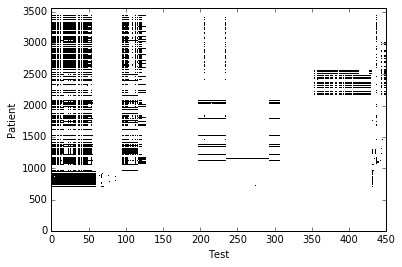

In [2]:
plt.pcolor(genoCodes,cmap='Greys',vmin=0,vmax=1)
plt.xlim([0.0, len(genoCodes[0])])
plt.ylim([0.0, len(genoCodes)])
xlo=plt.xlabel('Test')
ylo=plt.ylabel('Patient')
plt.savefig("rawdata.png", format="png")

## Determine threshold for the most common diagnosis codes, and pull them from ICD-10 database.
Set the threshold for how many patients are acceptable per diagnosis below. Diagnoses are hardcoded below, after being pulled from https://www.nuemd.com/icd-10/common-codes 

In [14]:
#looking at diagnosis codes
diagThreshold=50

commonCodes=[]
commonCodeinds=np.where(sum(diagCodes)>diagThreshold)[0]
commonCodeinds_sorted=sorted(range(len(commonCodeinds)), key=sum(diagCodes)[commonCodeinds].__getitem__)
for i in commonCodeinds_sorted:
    commonCodes.append(colVals[commonCodeinds[i]])


## Determine how many tests were performed per patient and plot.

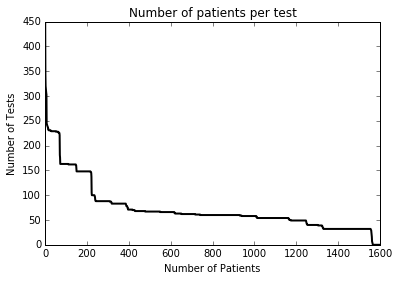

In [15]:
npt=[]
for i in range(0,1600):
    npt.append(len(np.where(sum(genoCodes)>i)[0]))
cax=plt.subplot(111)
plt.plot(range(0,1600),npt,color='black',lw=2)
xlo=plt.xlabel('Number of Patients')
ylo=plt.ylabel('Number of Tests')
plt.title('Number of patients per test')

plt.savefig('testsperpt.png', format='png')
plt.show()


## Group diagnosis codes roughly by category 
The most common diagnoses can be roughly grouped into a few categories - one attempt is below. These can also be used for the truncated SVD, though they don't provide any better clustering than the existing diagnoses.

In [17]:
#in reverse order with >50 diagnoses, so last is most common
commonDiags=['Radiculopathy','Vitamin D deficiency','Hypercholesterolemia','Anxiety disorder','Fatigue','Low back pain',
             'Mixed hyperlipidemia','Depressive disorder episode','Cocaine abuse','Long term opioid use',
             'Opioid abuse with intoxication','Alcohol abuse','Hyperlipidemia NOS','Hypothyroidism','Opioid abuse',
             'Esophageal reflux','Stimulant dependence','Diabetes','Anxiety','Chromosomal anomaly','Trichomoniasis',
             'Sedative dependence','Opioid dependence','','Candidiasis','STD screening','Hypertension',
             'Vaginitis','Long-term drug therapy','Adverse effect of drugs or medication']
groupNames=['pain/opioid','std','psychiatric','alcohol','stimulant/cocaine','weight-related','back pain','other']

#group indices for each diagnosis, in the same order as above
diagGroups=[6,7,5,2,7,6,5,2,4,0,0,3,5,5,0,7,4,5,2,7,1,0,0,7,1,1,5,1,0,0]
codeColumn=[colVals.index(i) for i in commonCodes]
diagDict={'Diagnosis':commonDiags,'Code':commonCodes,'Group': diagGroups,'GroupNames': groupNames,'CodeColumn':codeColumn}


## Preparation for the Lasso logistic regression
Restrict the number of tests and patients to a more compact dataset,and then one hot encode features. I also generate a list, testResultLabels, which are the assay name followed by the result on that test ("APOE2[C/C]"). Change ptThreshold to manipulate the sparsity of the dataset: 0 is the most sparse, where we use any tests that had more than 0 patients' data, and 1500 is very compact, with only approximately 20 tests per patient. This number can be chosen using the above figure, "Number of patients per test".

In [10]:
#how many patients had each test
ptThreshold=222 #0=more sparse, 222=compact subset w/>100 tests/pt, 1500=very compact, 20 tests/pt

# use all patients
#select data for each desired patient
numPts=len(genoCodes)
groupPtData=[genoCodesData[i] for i,g in enumerate(genoCodes)]

useTests=np.where(sum(genoCodes)>ptThreshold)[0]
#only use patients with any of these tests done
usePts=np.where([sum(i[useTests]) for i in groupPtData])[0]

#indices of patients to use, relative to original dataframe
usePtInds=[range(numPts)[i] for i in usePts]

#select tests and patients to use
categoryData=map(list, zip(*[alldata_copy[i] for i in usePtInds]))
    
#sklearn one hot encoding

# define example
testResultLabels=[]

for test in useTests:
    data = categoryData[indexAssaystart1+test]
    values = array(data)
    # integer encode
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(values)
    # binary encode
    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)  
    
    featInd=0
    uselabs=[]
    for feat in onehot_encoded.T:
        label=label_encoder.inverse_transform([argmax(onehot_encoded[np.where(feat==1)[0][0], :])])
        if label!='':
            testResultLabels.append(colVals[test+indexAssaystart1]+'['+label[0]+']')
            uselabs.append(featInd)
        featInd=featInd+1
    if test==useTests[0]:
        testResultData=onehot_encoded[0:,uselabs]
    else:
        testResultData=np.concatenate((np.asarray(testResultData),np.asarray(onehot_encoded[0:,uselabs])),axis=1)

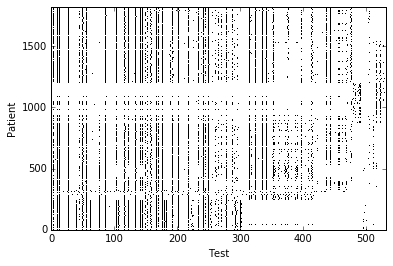

In [11]:
#plot one hot encoded data
plt.pcolor(testResultData,cmap='Greys',vmin=0,vmax=1)
plt.xlim([0.0, len(testResultData[0])])
plt.ylim([0.0, len(testResultData)])
xlo=plt.xlabel('Test')
ylo=plt.ylabel('Patient')
plt.savefig("onehot.png", format="png")

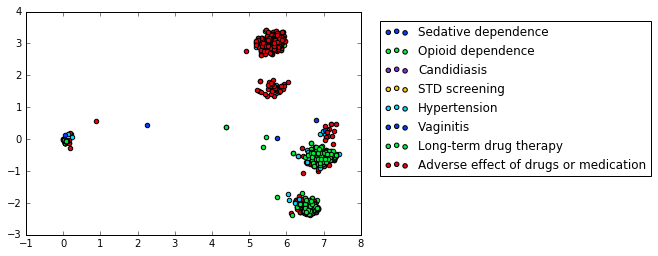

In [24]:
#try truncated SVD 
X=testResultData

X_pca = TruncatedSVD(n_components=3).fit_transform(X)

palette = np.array(sns.color_palette('bright',12))
fig_pca = plt.figure(figsize=(8,8))
diagCodes_usesvd=diagCodes[usePtInds].T[commonCodeinds[commonCodeinds_sorted[-9:]]]

fig = plt.figure()
ax = plt.subplot()
#for 3d
# ax = fig.add_subplot(111, projection='3d')
for i in range(len(diagCodes_usesvd)):
    ptInds=np.where(diagCodes_usesvd[i])[0]
    xdata = X_pca[ptInds,0]
    ydata = X_pca[ptInds,1]
    zdata = X_pca[ptInds,2]

    c_select = palette[i]
    #for 2d
    ax.scatter(xdata,ydata,c=c_select,label=diagDict['Diagnosis'][i+21])

    #for 3d
#     ax.scatter(xdata,ydata,zdata,c=c_select,label=labels[i])

ax.legend(bbox_to_anchor=(1.05, 0.97),loc=2, borderaxespad=0.2)
plt.savefig("tsvd_compactdata.png", format="png",bbox_inches='tight')
plt.show()

## Lasso logistic regression and accompanying plots

The lasso logistic regression is very tolerant of a sparse dataset, even the slightly more compact one that we have. I've also tuned parameters toward that end: the tolerance is set close to 0 to force the algorithm to return models that have converged, and alpha = 0.01 to deal with the sparsity.

not enough trials for Radiculopathy
not enough trials for Vitamin D deficiency
not enough trials for Hypercholesterolemia
not enough trials for Anxiety disorder


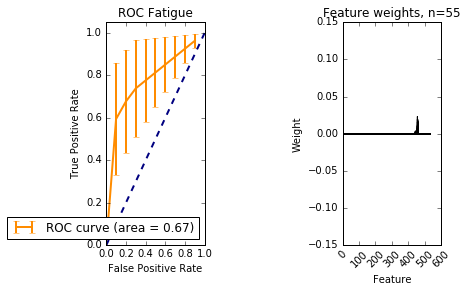

Low back pain AUC below 0.6
not enough trials for Mixed hyperlipidemia
not enough trials for Depressive disorder episode
not enough trials for Cocaine abuse
Long term opioid use AUC below 0.6
not enough trials for Opioid abuse with intoxication
Alcohol abuse AUC below 0.6
not enough trials for Hyperlipidemia NOS
not enough trials for Hypothyroidism
Opioid abuse AUC below 0.6
not enough trials for Esophageal reflux


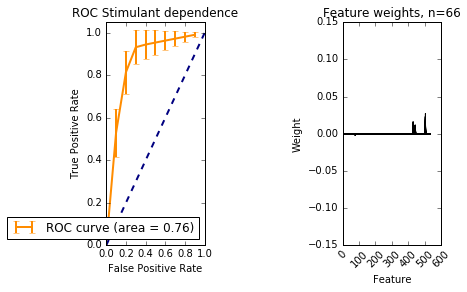

not enough trials for Diabetes


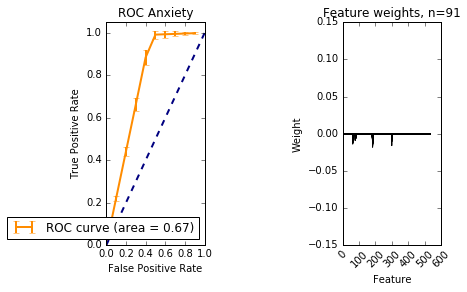

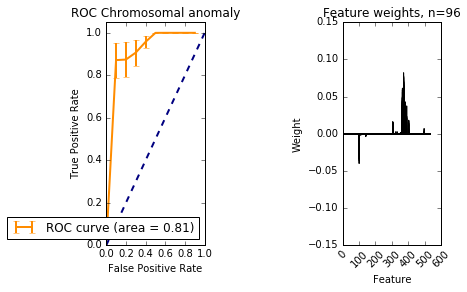

Chromosomal anomaly
r^2 on test data : 0.137313
not enough trials for Trichomoniasis


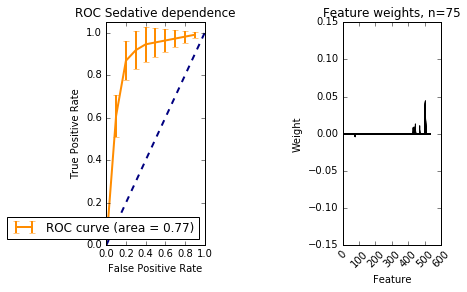

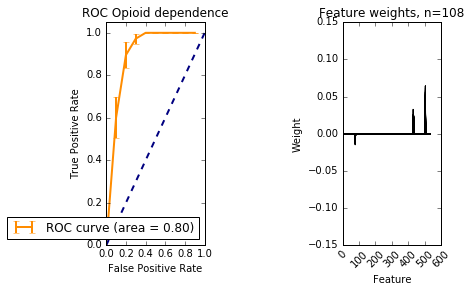

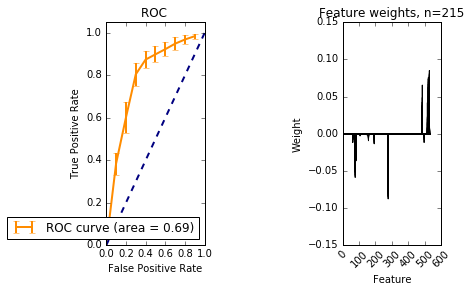

not enough trials for Candidiasis
not enough trials for STD screening


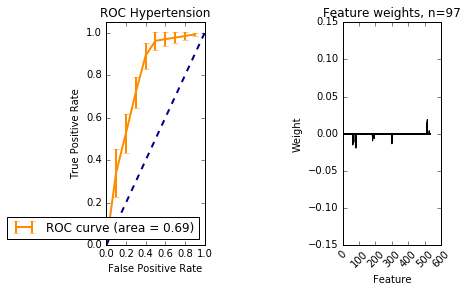

not enough trials for Vaginitis


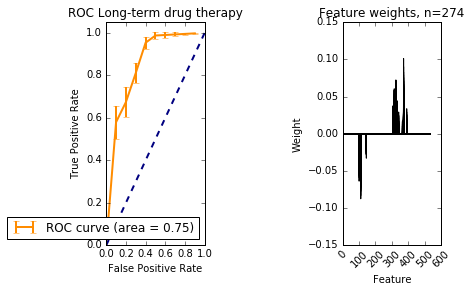

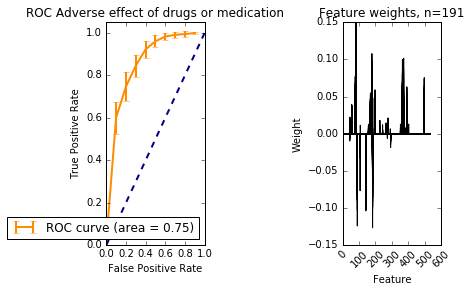

Adverse effect of drugs or medication
r^2 on test data : 0.138385


In [66]:
# lasso
from sklearn.metrics import roc_curve, auc, r2_score

#first checking for each of the major diagnoses
diagCodes_use=diagCodes[usePtInds]
falsepos=[]
truepos=[]
roc_auc=[]
codeTest=[]
predComps=[]
predCompsWeights=[]
r2_score_lasso=[]
acc=[]
coefs=[]
for sortedInd in range(len(commonCodeinds_sorted)):
    coefs.append([])
    codeInd=commonCodeinds[commonCodeinds_sorted[sortedInd]]
    catPtDiagUse=np.zeros(len(diagCodes_use))
    catPtDiagUse[np.where(diagCodes_use.T[codeInd])[0]]=1
    
    X=testResultData
    Y=catPtDiagUse
        
    trainfrac=8
    diagInds=np.where(catPtDiagUse==1)[0]
    if len(diagInds)<diagThreshold:
        print('not enough trials for '+diagDict['Diagnosis'][sortedInd])
        continue
    numReps=100
    #manually choosing training/testing samples because StratifiedShuffleSplit doesn't balance correctly
    for rep in range(numReps):
        nSampsD=len(diagInds)
        nondiagInds=np.where(catPtDiagUse==0)[0]
        nSampsND=len(nondiagInds)
        randsampsD=np.random.choice(range(0,nSampsD),nSampsD)
        randsampsD_OS=np.random.choice(range(0,nSampsD*trainfrac//10),nSampsND)
        randsampsND=random.sample(range(0,nSampsND),nSampsND)
        #to balance, use nSampsD (number of samples with diagnosis) for selecting non-diagnosed pts too
        trainsamps=np.concatenate(([randsampsD_OS[n] for n in range(0,nSampsND*trainfrac//10)],
                                   [randsampsND[n] for n in range(0,nSampsND*trainfrac//10)]),axis=0)
        testsamps=np.concatenate(([randsampsD_OS[n] for n in range(nSampsND*trainfrac//10,nSampsND)],
                                  [randsampsND[n] for n in range(nSampsND*trainfrac//10,nSampsND)]),axis=0)

        X_train, X_test = X[trainsamps], X[testsamps]
        Y_train, Y_test = Y[trainsamps], Y[testsamps]
        reg = Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=1000,normalize=False, 
                    positive=False, precompute=False, random_state=None,selection='cyclic', tol=0.0001, warm_start=False)
        reg.fit(X_train,Y_train)
        Y_preds=reg.predict(X_test)
        
        fpr, tpr, _ = roc_curve(Y_test, Y_preds)
        tpr_interp=np.interp(np.asarray(range(0,10,1))/10.0,fpr,tpr)
        falsepos.append(np.asarray(range(0,10,1))/10.0)
        truepos.append(tpr_interp)
        roc_auc.append(auc(np.asarray(range(0,10,1))/10.0, tpr_interp))

        codeTest.append(codeInd)
        r2_score_lasso.append(r2_score(Y_test, Y_preds))
        coefs[-1].extend(reg.coef_)
        
    m=max(roc_auc[-numReps:])
    ind=(roc_auc[-numReps:].index(m))
    #only plot if the maximum AUC observed is >0.6
    if np.mean(roc_auc[-numReps:])>0.6:
        fig=plt.figure()
        cax=plt.subplot(1,3,1)
        plt.errorbar(np.mean(falsepos[-numReps:],axis=0), np.mean(truepos[-numReps:],axis=0),np.std(truepos[-numReps:],axis=0), 
                     color='darkorange',lw=2,label='ROC curve (area = %0.2f)' % np.mean(roc_auc[-numReps:]))
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        xlo=plt.xlabel('False Positive Rate')
        ylo=plt.ylabel('True Positive Rate')
        titleobj=plt.title('ROC '+diagDict['Diagnosis'][sortedInd])
        plt.legend(loc="lower right")
        coefs[-1]=np.reshape(np.asarray(coefs[-1]),(numReps,len(coefs[-1])/numReps))
        cax=plt.subplot(1,3,3)
#         plt.plot(np.mean(coefs[-1],axis=0))
        for i in coefs[-1]:
            plt.plot(i,color='black')
        xlo=plt.xlabel('Feature')
        ylo=plt.ylabel('Weight')
        plt.ylim([-0.15, 0.15])
        
        titleobj=plt.title('Feature weights, n='+str(nSampsD))
        for tick in cax.get_xticklabels():
            tick.set_rotation(45)

        fig.savefig(diagDict['Diagnosis'][sortedInd]+'ROC_'+str(ptThreshold)+'ptmin_oversampled.eps', format='eps')
        plt.show()
        
        #sorted indices of regression coefficients
        reginds_sorted=sorted(range(len(np.mean(coefs[-1],axis=0))), key=np.abs(np.mean(coefs[-1],axis=0)).__getitem__,reverse=True)
        
        #save weights and titles of components that provide predictive power
        predCompsWeights.append([np.mean(coefs[-1],axis=0)[i] for i in reginds_sorted])
        predComps.append([diagDict['Diagnosis'][sortedInd],[testResultLabels[i] for i in reginds_sorted]])
        if r2_score_lasso[-1]>0.1:
            print diagDict['Diagnosis'][sortedInd]
            print("r^2 on test data : %f" % r2_score_lasso[-1])
#         else:
#             print(diagDict['Diagnosis'][sortedInd]+' r^2 below 0.1')
            
        coefs[-1]=list(coefs[-1])
    else:
        print(diagDict['Diagnosis'][sortedInd]+' AUC below 0.6')

            
